In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.gaussian_process import GaussianProcessRegressor, GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, Matern, ConstantKernel
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report, confusion_matrix

warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("AmesHousing.csv")
df.drop(columns=["Order", "PID", "Alley", "Pool QC", "Fence", "Misc Feature", "Fireplace Qu"], errors='ignore', inplace=True)

for col in df.columns:
    if df[col].dtype == 'object':
        df[col].fillna(df[col].mode()[0], inplace=True)
    else:
        df[col].fillna(df[col].median(), inplace=True)
for col in df.select_dtypes(include='object').columns:
    df[col] = LabelEncoder().fit_transform(df[col])

In [3]:
features = ['Gr Liv Area', 'Overall Qual', 'Garage Area', 'Total Bsmt SF', 'Year Built', '1st Flr SF']
target = 'SalePrice'

X = df[features]
y = np.log1p(df[target])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [5]:
kernel = ConstantKernel(1.0, (1e-3, 1e3)) * Matern(length_scale=1.0, nu=1.5) + WhiteKernel(noise_level=1.0)

In [6]:
gpr = GaussianProcessRegressor(kernel=kernel, normalize_y=True, n_restarts_optimizer=5)
gpr.fit(X_train, y_train)

GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=5, normalize_y=True)

In [7]:
y_pred, y_std = gpr.predict(X_test, return_std=True)

In [8]:
y_test_actual = np.expm1(y_test)
y_pred_actual = np.expm1(y_pred)

In [9]:
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))
r2 = r2_score(y_test_actual, y_pred_actual)

print(f"[Improved GPR] RMSE: {rmse:.2f}")
print(f"[Improved GPR] R² Score: {r2:.2f}")

[Improved GPR] RMSE: 30276.09
[Improved GPR] R² Score: 0.89


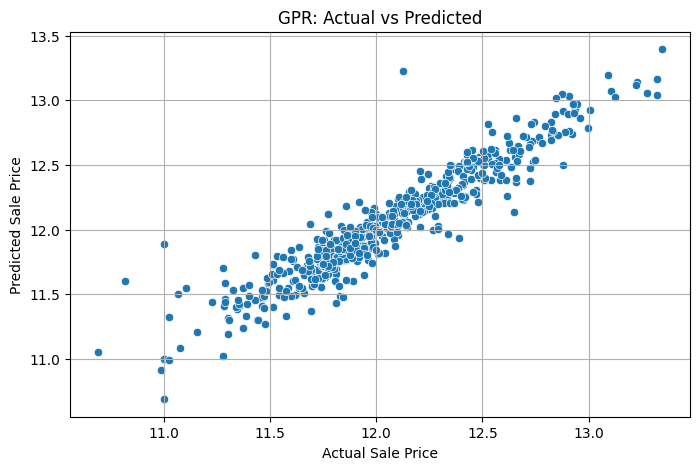

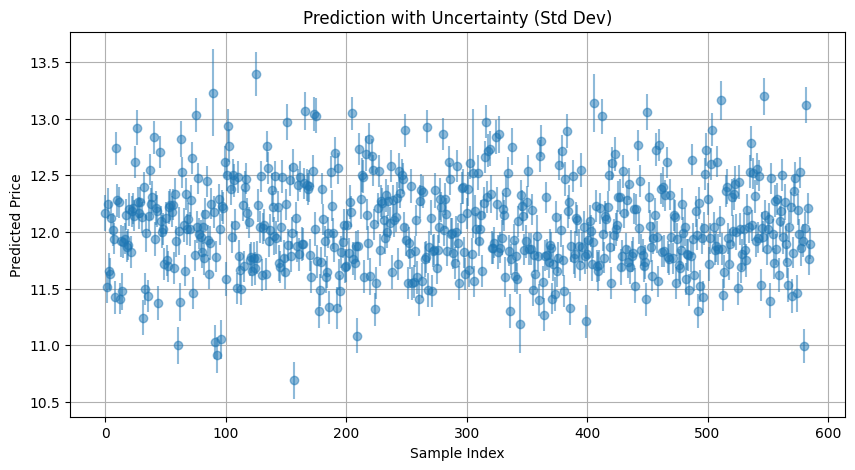

In [10]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Actual Sale Price")
plt.ylabel("Predicted Sale Price")
plt.title("GPR: Actual vs Predicted")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.errorbar(np.arange(len(y_pred)), y_pred, yerr=y_std, fmt='o', alpha=0.5)
plt.title("Prediction with Uncertainty (Std Dev)")
plt.xlabel("Sample Index")
plt.ylabel("Predicted Price")
plt.grid(True)
plt.show()


In [11]:
threshold = y.median()
y_train_class = np.where(y_train >= threshold, 1, 0)
y_test_class = np.where(y_test >= threshold, 1, 0)

gpc = GaussianProcessClassifier(kernel=RBF())
gpc.fit(X_train, y_train_class)

y_pred_class = gpc.predict(X_test)

accuracy = accuracy_score(y_test_class, y_pred_class)
report = classification_report(y_test_class, y_pred_class)

print(f"[GPC] Accuracy: {accuracy:.2f}")
print("[GPC] Classification Report:")
print(report)

[GPC] Accuracy: 0.91
[GPC] Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.89      0.91       277
           1       0.90      0.94      0.92       309

    accuracy                           0.91       586
   macro avg       0.92      0.91      0.91       586
weighted avg       0.92      0.91      0.91       586



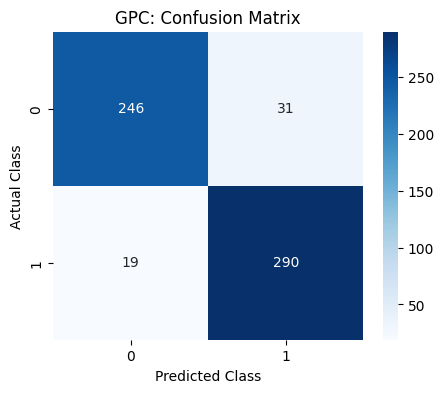

In [12]:
cm = confusion_matrix(y_test_class, y_pred_class)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.title("GPC: Confusion Matrix")
plt.show()

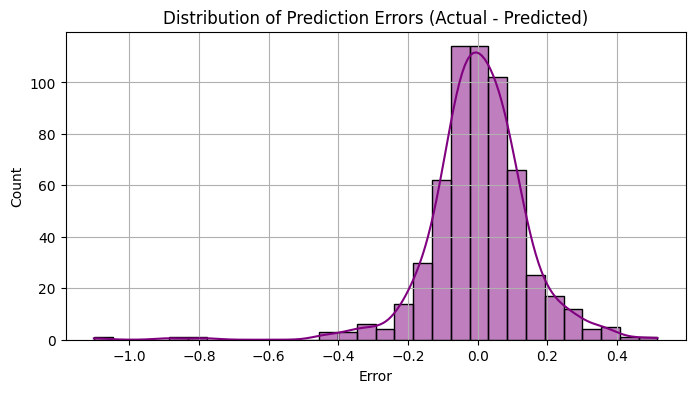

In [13]:
errors = y_test - y_pred

plt.figure(figsize=(8, 4))
sns.histplot(errors, bins=30, kde=True, color='purple')
plt.title("Distribution of Prediction Errors (Actual - Predicted)")
plt.xlabel("Error")
plt.ylabel("Count")
plt.grid(True)
plt.show()

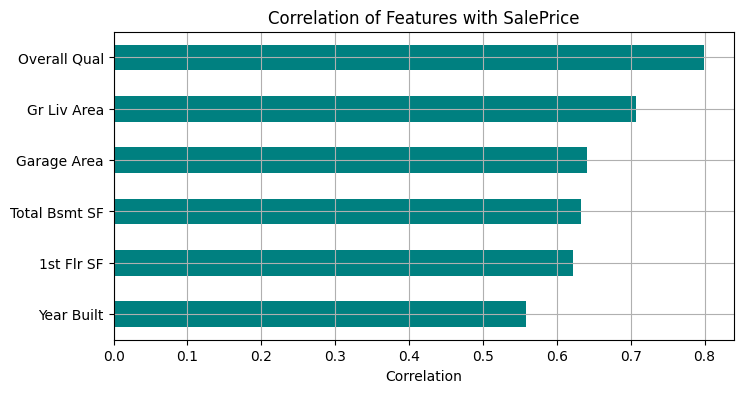

In [14]:
plt.figure(figsize=(8, 4))
correlations = df[features + ['SalePrice']].corr()['SalePrice'].drop('SalePrice')
correlations.sort_values().plot(kind='barh', color='teal')
plt.title("Correlation of Features with SalePrice")
plt.xlabel("Correlation")
plt.grid(True)
plt.show()